In [85]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf

In [86]:
import numpy as np
from keras.preprocessing import image
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator

In [87]:
CSV_PATH = "../../data/ground_truth.csv"
IMAGE_FOLDER = "data/"

In [88]:
df = pd.read_csv(CSV_PATH)

In [89]:
print("Prvih nekoliko redova iz CSV-a:")
print(df.head())

Prvih nekoliko redova iz CSV-a:
     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  


In [106]:
print("Nedostajuće vrednosti u CSV-u:")
print(df.isnull().sum())

Nedostajuće vrednosti u CSV-u:
image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64


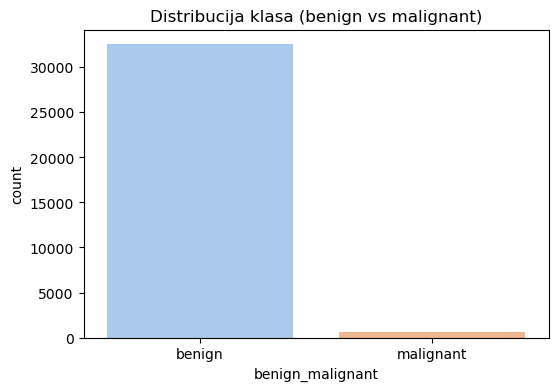

In [90]:
# Provera broja klasa (benign vs malignant)
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="benign_malignant", hue="benign_malignant", palette="pastel")
plt.title("Distribucija klasa (benign vs malignant)")
plt.show()

In [91]:
df['benign_malignant'].value_counts()

benign_malignant
benign       32542
malignant      584
Name: count, dtype: int64

In [92]:
# Prikaz nekoliko primera slika
def prikazi_slike(broj_slika=6):
    sample = df.sample(broj_slika)  # Nasumično biramo slike
    fig, axes = plt.subplots(1, broj_slika, figsize=(15, 5))

    for i, (idx, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(IMAGE_FOLDER, row["image_name"] + ".jpg")
        if os.path.exists(img_path):  # Proveravamo da li slika postoji
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{row['benign_malignant']}")
            axes[i].axis("off")
        else:
            axes[i].set_title("N/A")
            axes[i].axis("off")

    plt.show()

Result

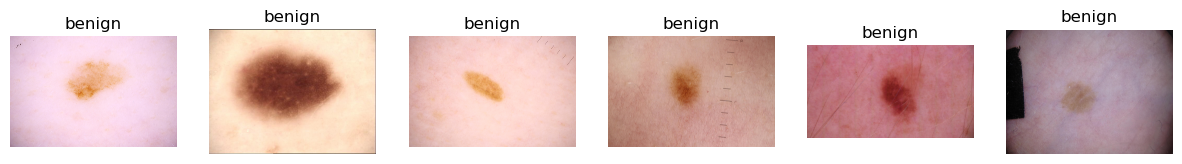

In [93]:
prikazi_slike()

After downsampling

In [94]:
# Pretpostavljamo da je DataFrame već učitan i da se zove df
# Prvo ćemo učitati podatke i podeliti ih na klasu 0 (benign) i klasu 1 (malignant)
data_class_0 = df[df['target'] == 0].sample(3000, random_state=42)  # Downsampling klase 0
data_class_1 = df[df['target'] == 1]  # Klasu 1 ostavljamo netaknutom

In [95]:
# Kombinovanje novih podataka u izbalansirani dataset
new_data = pd.concat([data_class_0, data_class_1])

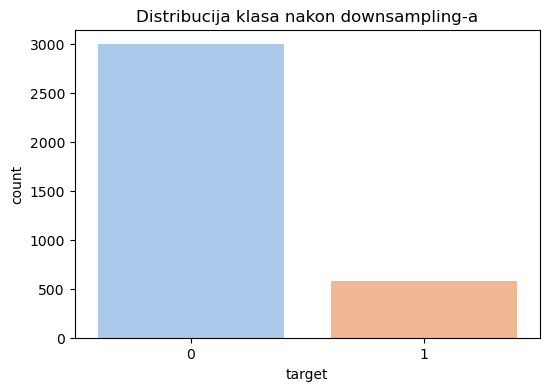

In [96]:
# Vizualizacija distribucije klasa sa modifikacijom prema FutureWarning-u
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=new_data, hue='target', palette='pastel', legend=False)  # Dodato 'hue' i 'legend=False'
plt.title('Distribucija klasa nakon downsampling-a')
plt.show()


In [97]:
new_data['target'].value_counts()

target
0    3000
1     584
Name: count, dtype: int64

2. Creating the Dataset class


In [110]:
# Funkcija za učitavanje slika i preprocesiranje
def load_and_preprocess_train(image_path, label, target_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.resize(img, target_size)
    img = tf.image.random_flip_left_right(img) 
    img = tf.image.random_flip_up_down(img)    
    img = tf.image.random_crop(img, size=[target_size[0], target_size[1], 3])
    img = img - [123.68, 116.78, 103.94] 
    img = img / [58.40, 57.12, 57.37] 
    return img, label

def load_and_preprocess_valid(image_path, label, target_size=(224, 224)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = img - [123.68, 116.78, 103.94]  
    img = img / [58.40, 57.12, 57.37] 
    return img, label 

class CustomDataset(Sequence):
    def __init__(self, image_paths, targets, batch_size=32, target_size=(224, 224), aug=None, shuffle=True, seed=42):
        self.image_paths = np.array(image_paths)
        self.targets = np.array(targets)
        self.batch_size = batch_size
        self.target_size = target_size
        self.aug = aug
        self.shuffle = shuffle
        self.seed = seed
        np.random.seed(self.seed) 
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))  # Broj epoha
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        image_paths_batch = [self.image_paths[i] for i in batch_indices]
        labels_batch = [self.targets[i] for i in batch_indices]
        
        # Učitavanje slika i etiketa
        images = [load_and_preprocess_train(img_path, label) for img_path, label in zip(image_paths_batch, labels_batch)]
        images, labels = zip(*images)
        
        images = np.array(images)
        labels = np.array(labels)
        
        # Primena augmentacije, ako postoji
        if self.aug:
            augmented = self.aug.flow(images, labels, shuffle=False)
            images, labels = next(augmented)
        
        return images, labels
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)  # Mešanje indeksa za sledeći epoch

In [111]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

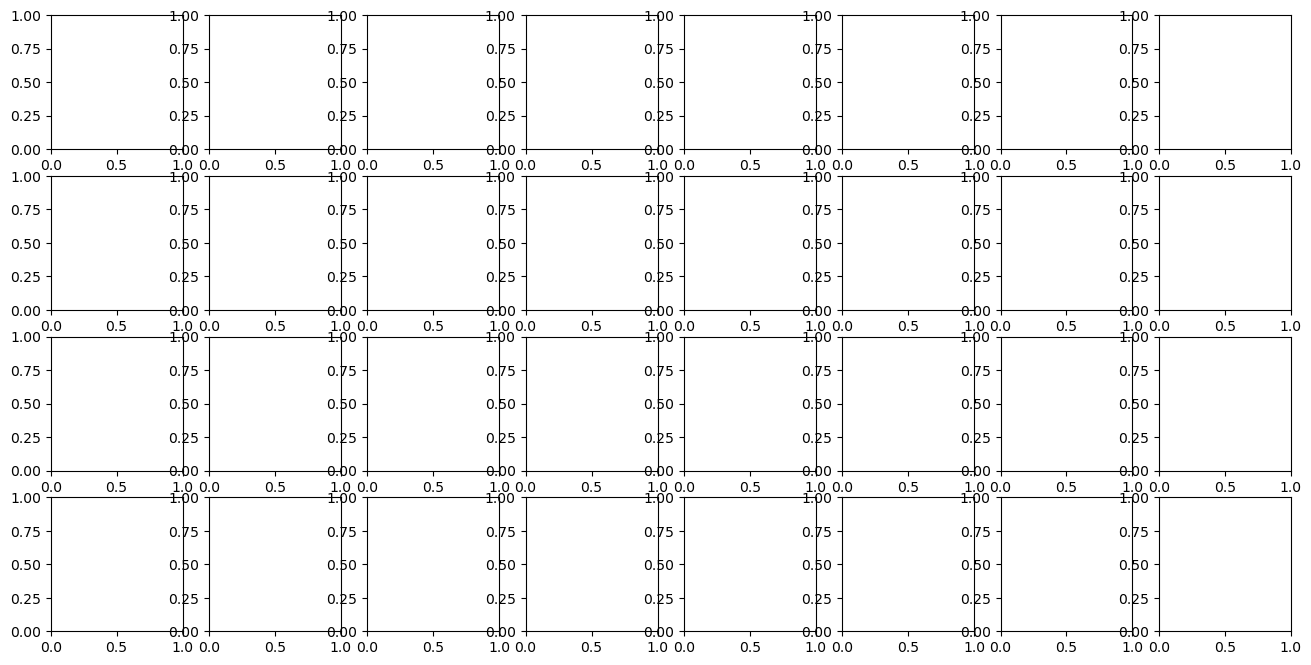

In [109]:
fig, ax = plt.subplots(4, 8, figsize=(16, 8))